In [24]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import AzureOpenAI, AzureChatOpenAI
from langgraph_supervisor import create_supervisor
import os

llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",
    api_version="2024-12-01-preview",
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_key=os.getenv('AZURE_OPENAI_API_KEY')
)

In [28]:
# workflow
# react agents
# supervisor agent

In [105]:
def spanish(state: MessagesState):

    input_user = state["messages"][0].content

    prompt = f"Translate the input from user to spanish: {input_user}"

    response = llm.invoke(prompt).content

    state["messages"].append({"role": "assistant", "content": response})

    return state["messages"][-1]

In [106]:
def french(state: MessagesState):

    input_user = state["messages"][0].content

    prompt = f"Translate the input from user to French: {input_user}"

    response = llm.invoke(prompt).content

    state["messages"].append({"role": "assistant", "content": response})

    return state["messages"][-1]

In [ ]:
class State(MessagesState):
    messages: list[str]
    is_French: bool

In [ ]:
def router(state: MessagesState):
    input_user = state["messages"][0].content

    if "french" in input_user or "French" in input_user:
        state["is_french"] = True

    elif "spanish" in input_user or "Spanish" in input_user:
        return "spanish"

In [108]:
def dummy(state: MessagesState):

    return state

In [109]:
workflow = StateGraph(MessagesState)

workflow.add_node("french", french)
workflow.add_node("spanish", spanish)
workflow.add_node("dummy", dummy)


workflow.add_edge(START, "dummy")


workflow.add_conditional_edges(
    "dummy",
    router,
    {
        "french": "french",
        "spanish": "spanish"
    }
)

app = workflow.compile()

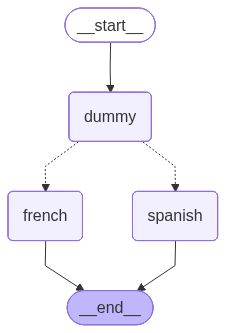

In [110]:
app

In [118]:
input_sample = {"messages": [{"role": "user", "content": "Translate this message to spanish: hey good morning, how are you"}]}

In [116]:
for step in app.stream(
    input_sample, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Translate this message to french: hey good morning, how are you
================================ Human Message =================================

Translate this message to french: hey good morning, how are you


In [119]:
app.invoke(input_sample)

{'messages': [HumanMessage(content='Translate this message to spanish: hey good morning, how are you', additional_kwargs={}, response_metadata={}, id='92514ca3-0053-4bd3-bd59-133f40c3368f'),
  {'role': 'assistant', 'content': 'Hola, buenos días, ¿cómo estás?'}]}